In [1]:
using Revise

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
    end;

In [111]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q .- Diagonal(sum(q, dims=2)|>vec)
end;

In [112]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
tmax = length(qs)
Profile.clear()
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  1.786275 seconds (14.46 k allocations: 4.292 GiB, 21.36% gc time)


In [20]:
## create commitor systems

using SparseArrays
TT = g - I
nm = size(TT, 1)
n = 900
bnd = nm - n
for i in bnd+1 : nm
    TT[i,:] .= 0
    TT[i,i] = 1
end

In [29]:
## create commitor terminal condition
term = spzeros(nm,n)
term[nm-n+1:end, :] = sparse(I, n,n);

In [46]:
## solve commitors

@time cs = TT\collect(term)

 16.270903 seconds (3.69 k allocations: 1.460 GiB, 2.22% gc time)


21600×900 Array{Float64,2}:
 0.0223644  0.0137357  0.00873506  …  5.15588e-57  9.15537e-59  -0.0
 0.028051   0.0172275  0.0109554      6.51521e-57  1.15691e-58  -0.0
 0.0333909  0.0205022  0.0130366      8.07156e-57  1.43323e-58  -0.0
 0.0367428  0.0225512  0.014337       9.79561e-57  1.73924e-58  -0.0
 0.0392919  0.0241033  0.0153204      1.21507e-56  2.15717e-58   0.0
 0.0410873  0.0251903  0.0160073   …  1.54801e-56  2.74791e-58  -0.0
 0.0421008  0.0257968  0.0163886      2.04699e-56  3.63315e-58   0.0
 0.0421396  0.0258081  0.0163923      2.84297e-56  5.04515e-58   0.0
 0.0412607  0.0252605  0.0160417      4.17336e-56  7.40499e-58   0.0
 0.0402552  0.024635   0.0156415      6.27457e-56  1.11321e-57  -0.0
 0.0396137  0.0242259  0.0153768   …  9.59073e-56  1.70142e-57   0.0
 0.0416093  0.0253874  0.0160976      8.94701e-56  1.58777e-57  -0.0
 0.0465863  0.0282578  0.017872       6.78167e-56  1.20482e-57  -0.0
 ⋮                                 ⋱                                
 0.0  

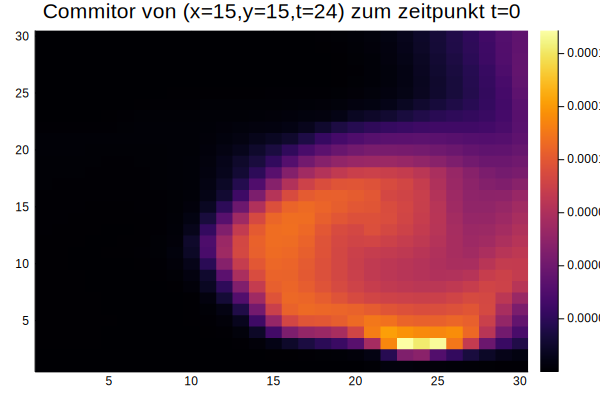

In [74]:
using Plots
heatmap(reshape(cs[1:900,15*30+15],30,30), title="Commitor von (x=15,y=15,t=24) zum zeitpunkt t=0")

In [87]:
# cluster commitors
ass=EAMC.optimize_maxassignment(cs[1:900,:], 10);

In [78]:
sum(ass, dims=1)
# nicht alle cluster werden assigned?!

1×12 Array{Float64,2}:
 5.0  0.0  3.0  85.0  150.0  655.0  0.0  2.0  0.0  0.0  0.0  0.0

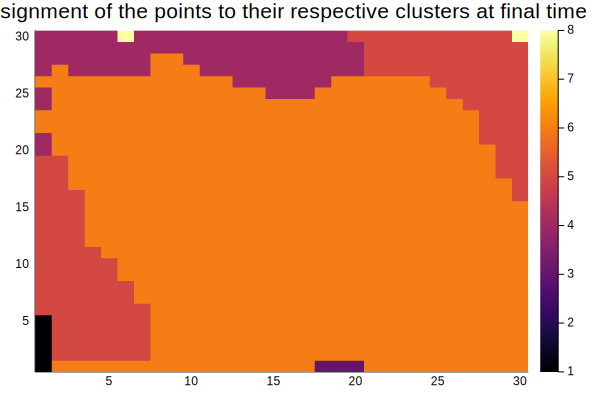

In [114]:
cl = map(i->i[2], argmax(ass, dims=2))
cl = reshape(cl, 30,30)
heatmap(cl, title="assignment of the points to their respective clusters at final time")

┌ Info: Saved animation to 
│   fn = /Users/alex/Desktop/code/generators/tmp.gif
└ @ Plots /Users/alex/.julia/packages/Plots/RsO3g/src/animation.jl:98


Plots.AnimatedGif("/Users/alex/Desktop/code/generators/tmp.gif")
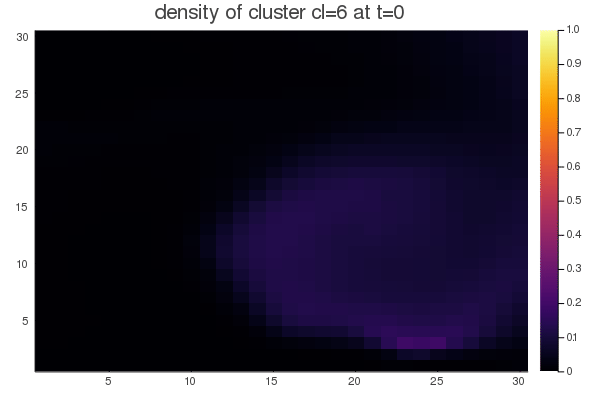

In [139]:
cluster = 6
@gif for i=0:length(dt)-1
    heatmap(reshape(cs[(1:900).+900*(i),:] * ass[:,cluster], 30, 30), title="density of cluster cl=$cluster at t=$i", clims=(0,1))
    end

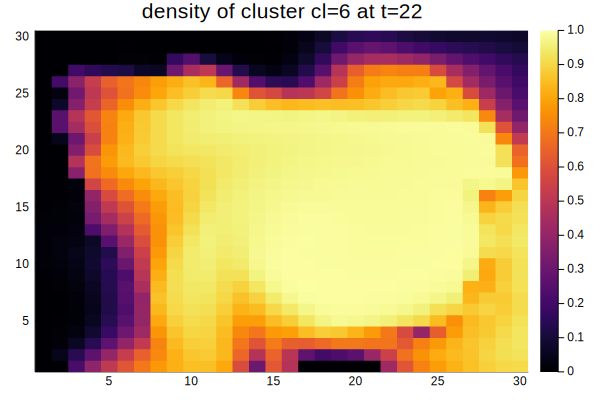

In [188]:
let i = 22
heatmap(reshape(cs[(1:900).+900*(i),:] * ass[:,cluster], 30, 30), title="density of cluster cl=$cluster at t=$i", clims=(0,1))
end